In [242]:
import pandas as pd
#Stores all the training stats and models.
trainingObjects = {}

#Customer atrributes after transformation
custCols = ['custAge', 'marital', 'schooling', 'default', 'housing','loan', 'profession_admin.', \
            'profession_blue-collar', 'profession_entrepreneur', 'profession_housemaid', 'profession_management',\
            'profession_retired', 'profession_self-employed', 'profession_services', 'profession_student', \
            'profession_technician', 'profession_unemployed']

#Columns to be dropped, as they are highly correlated to other columns
dropColumns = ['pmonths','pastEmail','emp.var.rate','euribor3m']

In [265]:
def uniqueValues(df, categoricalCols):
    for col in categoricalCols:
        print('{c}:{v}'.format(c=col,v=df.loc[:,col].unique()))
    
def createDistribution(inputdf):
    """Creates distribution of all the columns in the input dataframe."""
    import matplotlib.pyplot as plt
    import seaborn as sns
               
    for col in inputdf.columns:
        if inputdf[col].dtype=='object':
            plt.figure(figsize=(15,5))
            ax = sns.countplot(x=col, data=inputdf, order=inputdf.loc[:,col].value_counts().index)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
            plt.tight_layout()
            plt.title(col)
            plt.show()
        elif inputdf[col].dtype in (int,float):
            plt.figure(figsize=(15,5))
            inputdf[col].hist()
            plt.tight_layout()
            plt.title(col)
            plt.show()

def distributionByTarget(inputdf,targetCol):
    """Creates a distribution of target value for each categorical columns."""
    import matplotlib.pyplot as plt
    import seaborn as sns
    allColumns = list(inputdf.columns)
    allColumns.remove(targetCol)      
    for col in allColumns:
        temp_df = inputdf.loc[:,[targetCol,col]]
        temp_df.loc[:,'count']=1
        if inputdf.loc[:,col].dtype==object:
            temp_df.loc[:,'percent'] = temp_df.groupby([col,targetCol])['count'].transform('sum')/temp_df.groupby([col])['count'].transform('sum')
            temp_df.pivot_table(columns=targetCol,index=col, values='percent').plot(kind='bar', stacked=True, figsize=(20,5),rot=40)
            plt.title(col)
            plt.tight_layout()
            plt.show()
        elif inputdf.loc[:,col].dtype in (int,float):
            temp_df.loc[:,'count'] = temp_df.groupby([col,targetCol])['count'].transform('sum')
            sns.scatterplot(x=col,y='count',data=temp_df, hue=targetCol)
            plt.title(col)
            plt.tight_layout()
            plt.show()
            
def getHighProbValue(inputdf,groupCols,valueCol):
    """Returns a dataframe with most occuring value from valueCol within groups of groupCol."""
    
    colGrpVal = groupCols+[valueCol]
    dfNotNullSchooling = inputdf.loc[inputdf.loc[:,valueCol].notnull(),colGrpVal]
    dfNotNullSchooling = dfNotNullSchooling.sort_values(colGrpVal).reset_index()
    dfNotNullSchooling['count']=1
    dfNotNullSchooling.loc[:,'probValForGrp'] = dfNotNullSchooling.groupby(colGrpVal)['count'].transform('sum')\
    /dfNotNullSchooling.groupby(groupCols)['count'].transform('sum').fillna(0)
    dfNotNullSchooling = dfNotNullSchooling.drop(columns=['index','count'])
    dfNotNullSchooling = dfNotNullSchooling.drop_duplicates()
    dfNotNullSchooling = dfNotNullSchooling.sort_values(groupCols+['probValForGrp'],ascending=False)
    return dfNotNullSchooling.groupby(groupCols).head(1).reset_index().drop(columns='index')

def fillnaWithHighOccrance(dfToUse, groupCols, valCol, cutOff=0.4):
    """Fills nulls in valCol with high occurance value, when grouped by groupCol. High occurance with
    at least 40% occurance.
    dfToUse: Dataframe with all required columns of grouping and value columns.
    groupCols: List of grouping column/s.
    valCol: Column that needs to be calculated frequency on.
    cutOff: Cut off of minimum probability occurances to be considered as high occurance."""

    dfHighProbValues = getHighProbValue(dfToUse.copy(),groupCols,valCol)
    dfHighProbValues = dfHighProbValues.dropna()
    dfHighProbValues = dfHighProbValues.loc[dfHighProbValues.loc[:,'probValForGrp']>=cutOff,groupCols+[valCol]]\
    .set_index(groupCols).to_dict()
    
    #records high occurance these columns for future use (prediction).
    trainingObjects['HighOcc_'+''.join(groupCols)+valCol]=dfHighProbValues
    
    dfToUse = dfToUse.set_index(groupCols).fillna(dfHighProbValues).reset_index()
    
    #records high occurance of valCol column for future use (prediction).
    trainingObjects['HighOcc_'+valCol]= dfToUse.loc[:,valCol].mode()[0]
    
    #Filling up any nulls that are left with most frequent value over all.
    dfToUse.loc[:,valCol] = dfToUse.loc[:,valCol].fillna(trainingObjects['HighOcc_'+valCol])
    
    return dfToUse

def transformFeatures(inputdf):
    """Transforms the text features into numeric, either by oridnal or One hot encoding depending on the feature."""
    inputdf = inputdf.replace('yes',1)
    inputdf = inputdf.replace('no',0)
    inputdf.loc[:,'schooling'] = inputdf.loc[:,'schooling'].map({'illiterate':0,'basic.4y':1, \
                                                                             'basic.6y':1, 'basic.9y':1, \
                                                                             'high.school':2,'professional.course':3,\
                                                                             'university.degree':4})
    inputdf.loc[:,'marital'] = inputdf.loc[:,'marital'].map({'single':0,'married':1,'divorced':1})
    inputdf.loc[:,'month'] = inputdf.loc[:,'month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,\
                                                                     'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,\
                                                                     'nov':11,'dec':12})
    inputdf.loc[:,'day_of_week'] = inputdf.loc[:,'day_of_week'].map({'mon':1,'tue':2,'wed':3,\
                                                                                 'thu':4,'fri':5,'sat':6,'sun':7})
    inputdf.loc[:,'poutcome'] = inputdf.loc[:,'poutcome'].map({'failure':0,'nonexistent':0.5,'success':1})

    inputdf.loc[:,'contact_cellular'] = inputdf.loc[:,'contact'].map({'cellular':1,'telephone':0})
    inputdf = inputdf.drop(columns='contact')
    return pd.get_dummies(inputdf)

def fillnaWtihRegression(inputdf, targetCol):
    """Predicting NULLs using regression algorithms, using all other columns as features.
    Returns predicted values for Nulls with same index as original dataframe passsed."""
    from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import accuracy_score
    
    pipeline = Pipeline(steps=[('scaler',StandardScaler()),\
                           ('estimator', LinearRegression(fit_intercept=True,n_jobs=-1))])
    
    params_grid = [{
                'estimator':[LinearRegression(fit_intercept=True,n_jobs=-1,normalize=True)]
                },
                {
                'estimator': [Lasso(fit_intercept=True,random_state=42)]
                },
                {
                'estimator':[ElasticNet(random_state=42)]
                }
              ]
    
    train_df = inputdf.dropna(subset=[targetCol]).astype(float)
    predict_df = inputdf.loc[inputdf.loc[:,targetCol].isnull(),:].drop(columns=targetCol).astype(float)
    
    X = train_df.drop(columns=targetCol)
    y = train_df.loc[:,targetCol]
    X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

    
    clf = GridSearchCV(pipeline,params_grid, cv=3, scoring=score)
    clf.fit(X_train,y_train)
    print('Best Score:',clf.best_score_)
    
    #Saving model for prediction.
    trainingObjects['custAge_model']=clf
    print('dtypes: ',predict_df.dtypes)
    return np.around(clf.best_estimator_.predict(predict_df),0)
    

def rsme_error(y_actual, y_predicted):
    """Returns the Root Mean Sqaured Error of predicted values from the actuals."""
    from sklearn.metrics import mean_squared_error
    from math import sqrt

    return sqrt(mean_squared_error(y_actual, y_predicted))

from sklearn.metrics import make_scorer
score = make_scorer(rsme_error, greater_is_better=False)

def printTestMetrics(model, X_test, y_test):
    from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, roc_curve
    import matplotlib.pyplot as plt
    import scikitplot as skplt
    
    print('---------------------------Train Score-------------------------')
    print('Best Train Score:',cvModels.best_score_)
    print('Best Model:',cvModels.best_estimator_)
    print('\nTop model for each algorithm.\n',getEstimatorResults(cvModels,'roc_auc').sort_values('mean_test_roc_auc',ascending=False))
    
    print('---------------------------Test Score-------------------------')
    y_predict = model.best_estimator_.predict(X_test)
#     y_predict_proba = model.best_estimator_.predict_proba(X_test)
    
    print('Test ROC AUC Score:',roc_auc_score(y_test,y_predict))
    print('Test F1 Score:',f1_score(y_test,y_predict))
    print('Test Recall Score:',recall_score(y_test,y_predict))
    print('Confusion matrix:\n',confusion_matrix(y_test, y_predict))
    skplt.metrics.plot_roc(y_test, model.best_estimator_.predict_proba(X_test))
    plt.show()

def getTrainedClassModel(inputdf, targetCol):
    from sklearn.pipeline import Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV, train_test_split
    
    X = inputdf.drop(columns=targetCol).astype(float)
    y = inputdf.loc[:,targetCol].astype(float)
    
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

    pipeline = Pipeline(steps=[('scaler',StandardScaler()),\
                               ('estimator', LogisticRegression(random_state=42))])

    params_grid = [{
                    'estimator':[LogisticRegression(random_state=42)]
                     ,
                    'estimator__penalty': ['l1', 'l2']
                    },
                    {
                    'estimator': [RandomForestClassifier(n_estimators=300,n_jobs=-1,random_state=42)]
                     ,
                    'estimator__max_depth': [15,30,45]
                    },
                    {
                    'estimator': [GradientBoostingClassifier(n_estimators=300,random_state=42)]
                     ,
                    'estimator__learning_rate': [0.01,0.1,0.25]
                    }
                  ]

    clf = GridSearchCV(pipeline, params_grid, cv=3, scoring=['recall','f1','roc_auc'], refit='roc_auc')
    clf.fit(X_train,y_train)
    
    printTestMetrics(clf, X_test, y_test)
    trainingObjects['responded_model']=clf
    return clf

def getEstimatorName(params):
    estimatorParams = str(dict(params)['estimator'])
    return estimatorParams[0:estimatorParams.find('(',0)]

def getEstimatorResults(model,score):
    """Returns top model for different estimators, using mean test score to pick the top model."""
    import warnings
    warnings.filterwarnings(action='once')
    gridCVResult = pd.DataFrame(model.cv_results_)
    gridCVResult.loc[:,]['estimator'] = gridCVResult.loc[:,]['params'].map(getEstimatorName)
    return gridCVResult.groupby('estimator').apply(lambda x: x.sort_values('rank_test_'+score).head(1))[['params','mean_test_'+score]]

def cleanDataSet(inputdf):
    """Returns a cleaned and transformed dataset as per the training cycle."""
    import numpy as np
    
    #Replace missing values with NaNs
    dfFilledNA = inputdf.replace('unknown',np.nan)
    dfFilledNA = dfFilledNA.replace(float('nan'),np.nan)
    
    #Filling up nulls in schooling using high occurance for groups of profession.
    dfFilledNA = dfFilledNA.set_index(['profession']).fillna(trainingObjects['HighOcc_'+'profession'+'schooling']).reset_index()
    #Filling any left over nulls with most frequent value in schooling.
    dfFilledNA['schooling'] = dfFilledNA['schooling'].fillna(trainingObjects['HighOcc_'+'schooling'])
    
    #Filling up nulls in default using high occurance for groups of custAge and profession.
    dfFilledNA = dfFilledNA.set_index(['custAge','profession']).fillna(trainingObjects['HighOcc_'+'custAge'+'profession'+'default']).reset_index()
    #Filling any left over nulls with most frequent value in default.
    dfFilledNA['default'] = dfFilledNA['default'].fillna(trainingObjects['HighOcc_'+'default'])
    
    #Filling up nulls in profession using high occurance for groups of custAge and schooling.
    dfFilledNA = dfFilledNA.set_index(['custAge','schooling']).fillna(trainingObjects['HighOcc_'+'custAge'+'schooling'+'profession']).reset_index()
    #Filling any left over nulls with most frequent value in profession.
    dfFilledNA['profession'] = dfFilledNA['profession'].fillna(trainingObjects['HighOcc_'+'profession'])
    
    #Filling up nulls in day_of_week with randomly choice a day from the week.
    dfFilledNA.loc[:,'day_of_week'] = dfFilledNA['day_of_week'].fillna(pd.Series(np.random.choice(trainingObjects['day_of_week'],size= dfFilledNA.shape[0]),index=dfFilledNA.index))
    
    #Filling up nulls in loan, housing and marital with most frequent values.
    dfFilledNA.loc[:,'loan'] = dfFilledNA.loc[:,'loan'].fillna(dfFilledNA.loc[:,'loan'].mode()[0])
    dfFilledNA.loc[:,'housing'] = dfFilledNA.loc[:,'housing'].fillna(dfFilledNA.loc[:,'housing'].mode()[0])
    dfFilledNA.loc[:,'marital'] = dfFilledNA.loc[:,'marital'].fillna(dfFilledNA.loc[:,'marital'].mode()[0])
    
    #Filling up nulls in custAge by predicting values based on other customer attributes, using linear regression.
    
    #Preparing dataframe for linear regression model.
    dfTransformed = transformFeatures(dfFilledNA.copy())
    dfToPredict = dfTransformed.loc[dfTransformed.loc[:,'custAge'].isnull(),custCols].drop(columns='custAge').astype(float)
    
    dfTransformed.loc[dfTransformed.custAge.isnull(),'custAge'] = np.around(trainingObjects['custAge_model'].best_estimator_.predict(dfToPredict),0)
    
    dfTransformed = dfTransformed.drop(columns=dropColumns)
    return dfTransformed
    
    
def predictCustomerForCampaign(inputdf, custAgeModel):
    """Returns prediction for given dataset."""
    #Cleaning and transforming dataset.
    dfClean = cleanDataSet(inputdf)
    
    #Return predicted values.
    predictedValues = trainingObjects['responded_model'].best_estimator_.predict(dfClean)
    
    #Replace all the 1s and 0s with yes and no.
    
    return np.where(predictedValues==0.0,'no','yes')

In [244]:
dfRawMarketing = pd.read_csv('marketing_training.csv')
dfRawMarketing.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,responded
0,55.0,admin.,single,university.degree,unknown,no,no,cellular,nov,mon,...,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,999.0,0,no
1,NaN,blue-collar,married,NaN,no,no,no,cellular,jul,mon,...,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,999.0,0,no
2,42.0,technician,married,high.school,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,999.0,0,no
3,55.0,management,divorced,NaN,unknown,yes,yes,cellular,jul,wed,...,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,999.0,0,no
4,NaN,admin.,divorced,university.degree,no,yes,no,cellular,may,tue,...,1,failure,-1.8,92.893,-46.2,1.291,5099.1,999.0,1,no


### Exploratory Data Analysis

In [245]:
dfRawMarketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7414 entries, 0 to 7413
Data columns (total 22 columns):
custAge           5610 non-null float64
profession        7414 non-null object
marital           7414 non-null object
schooling         5259 non-null object
default           7414 non-null object
housing           7414 non-null object
loan              7414 non-null object
contact           7414 non-null object
month             7414 non-null object
day_of_week       6703 non-null object
campaign          7414 non-null int64
pdays             7414 non-null int64
previous          7414 non-null int64
poutcome          7414 non-null object
emp.var.rate      7414 non-null float64
cons.price.idx    7414 non-null float64
cons.conf.idx     7414 non-null float64
euribor3m         7414 non-null float64
nr.employed       7414 non-null float64
pmonths           7414 non-null float64
pastEmail         7414 non-null int64
responded         7414 non-null object
dtypes: float64(7), int64(4), ob

In [246]:
dfRawMarketing.describe()

,custAge,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail
count,5610.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000,7414.000000
mean,40.009804,2.518344,960.024548,0.184111,0.052091,93.570708,-40.561316,3.583141,5165.224251,959.797028,0.361883
std,10.574616,2.695055,192.845029,0.516775,1.568399,0.578345,4.649800,1.744865,73.108669,193.969418,1.261668
min,18.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000
25%,32.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000,999.000000,0.000000
50%,38.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.857000,5191.000000,999.000000,0.000000
75%,47.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,999.000000,0.000000
max,94.000000,40.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,999.000000,18.000000


In [247]:
#Looing for what are the unique and unusual values in the categorical columns.
catCols = ['profession','marital','schooling','default','housing','loan','contact','month','day_of_week','poutcome','responded']
uniqueValues(dfRawMarketing, catCols)

profession:['admin.' 'blue-collar' 'technician' 'management' 'services' 'unemployed'
 'housemaid' 'unknown' 'self-employed' 'retired' 'student' 'entrepreneur']
marital:['single' 'married' 'divorced' 'unknown']
schooling:['university.degree' nan 'high.school' 'basic.4y' 'basic.9y'
 'professional.course' 'basic.6y' 'unknown' 'illiterate']
default:['unknown' 'no' 'yes']
housing:['no' 'yes' 'unknown']
loan:['no' 'yes' 'unknown']
contact:['cellular' 'telephone']
month:['nov' 'jul' 'may' 'aug' 'apr' 'jun' 'mar' 'oct' 'sep' 'dec']
day_of_week:['mon' 'wed' 'tue' 'fri' 'thu' nan]
poutcome:['nonexistent' 'failure' 'success']
responded:['no' 'yes']


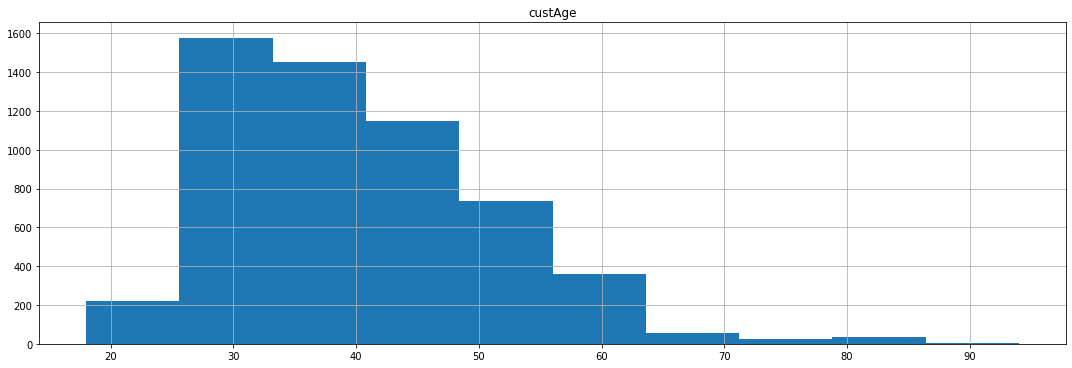

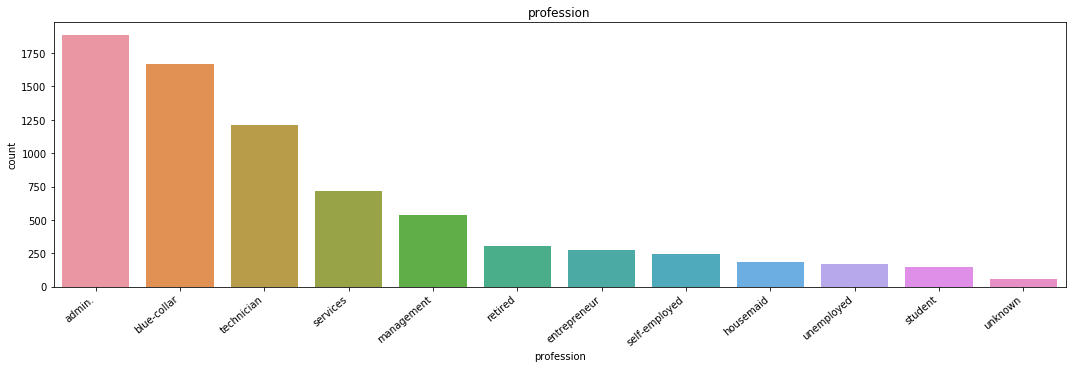

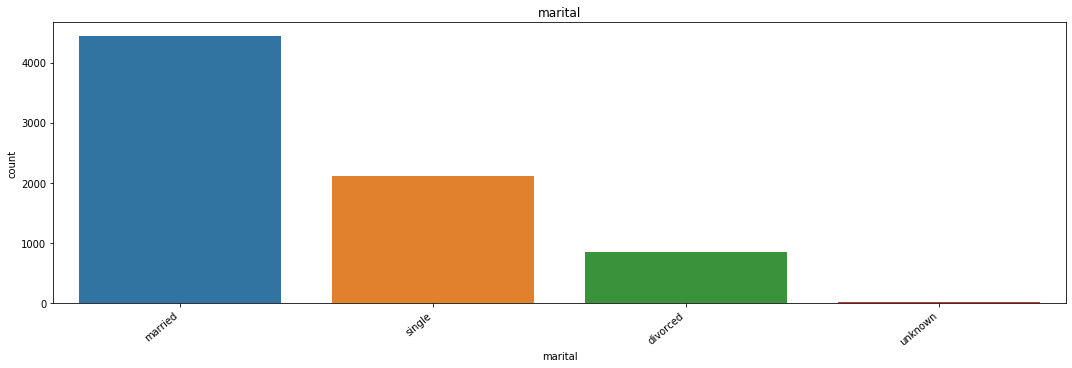

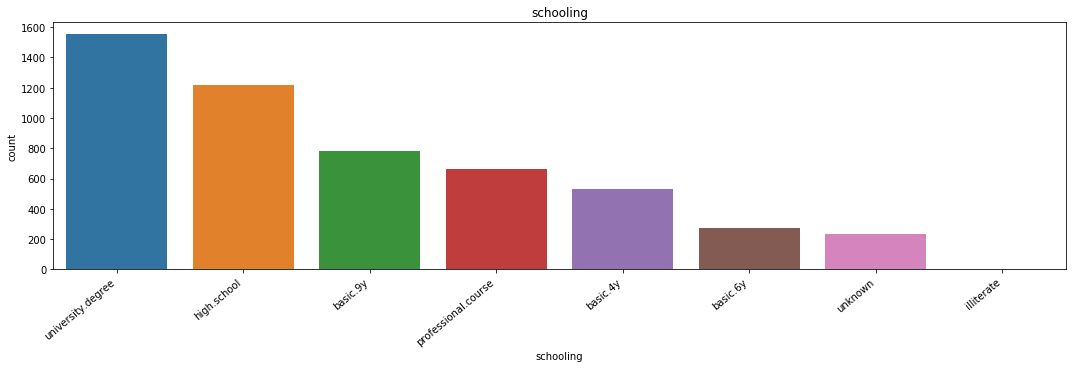

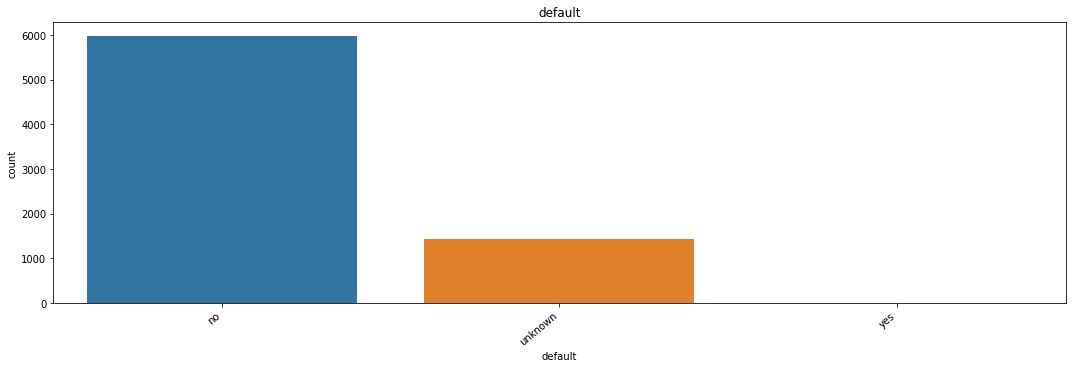

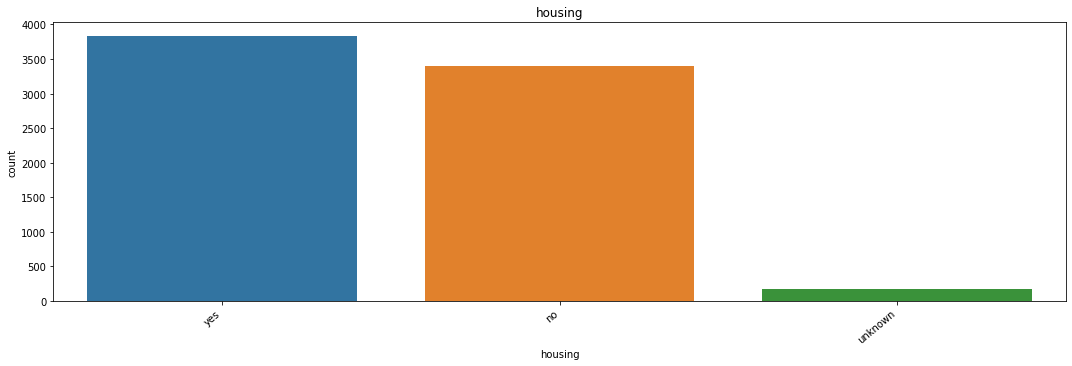

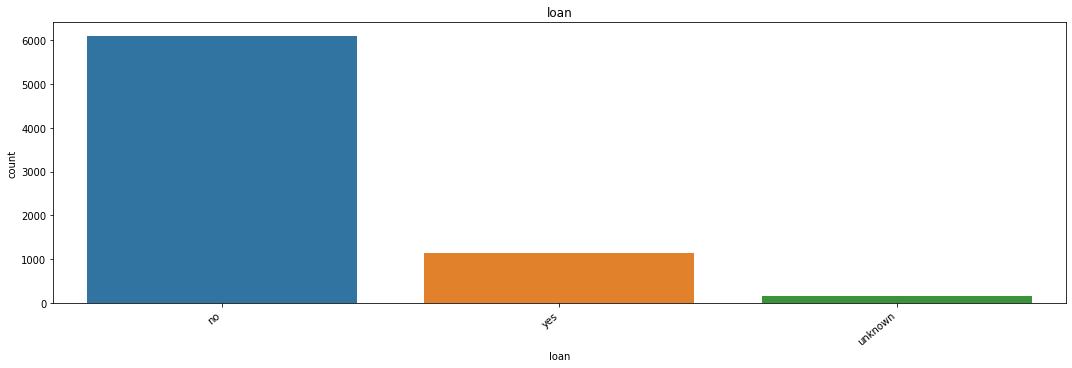

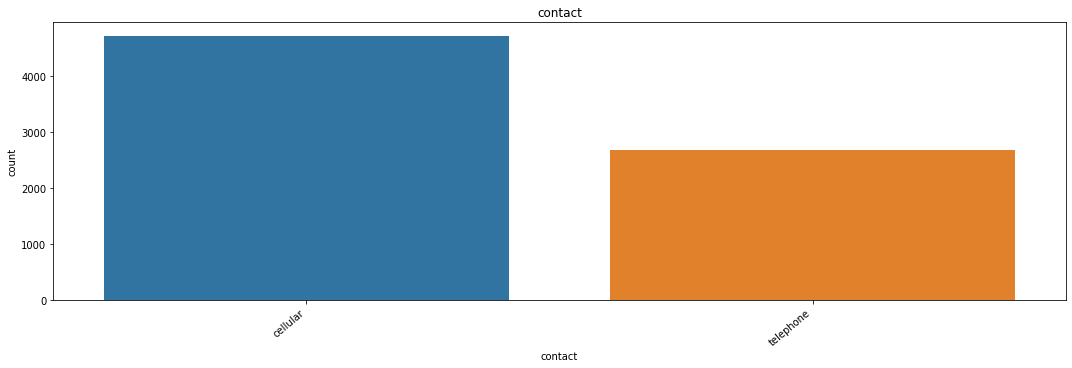

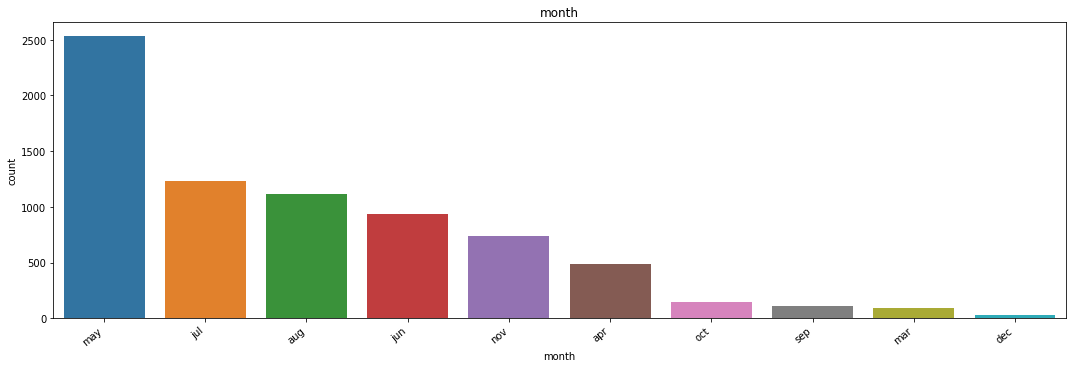

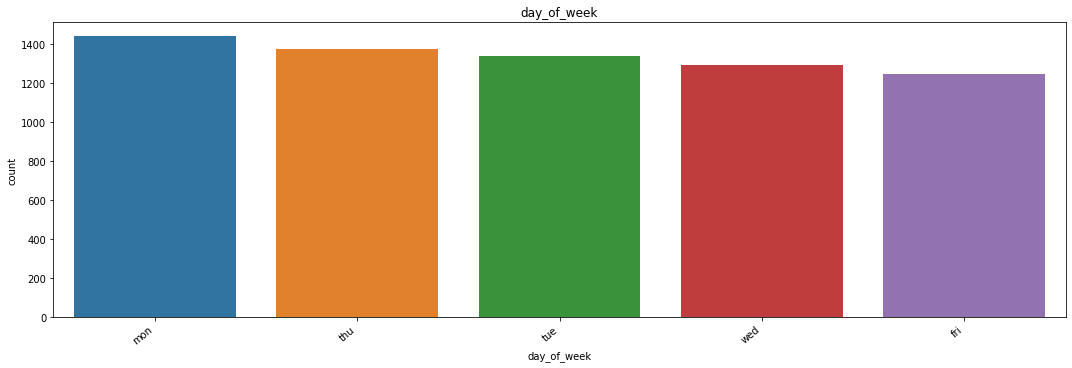

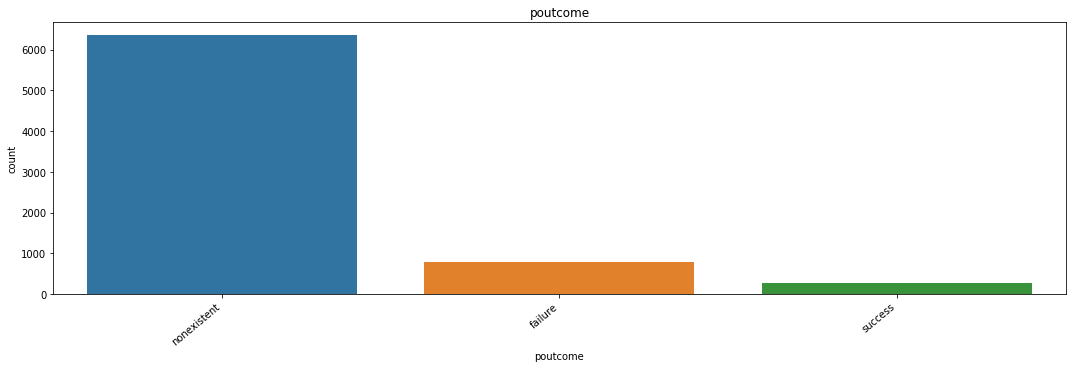

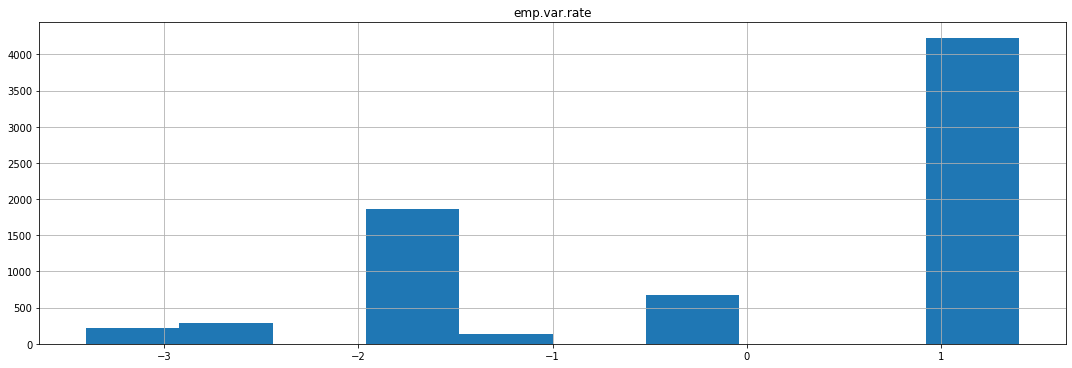

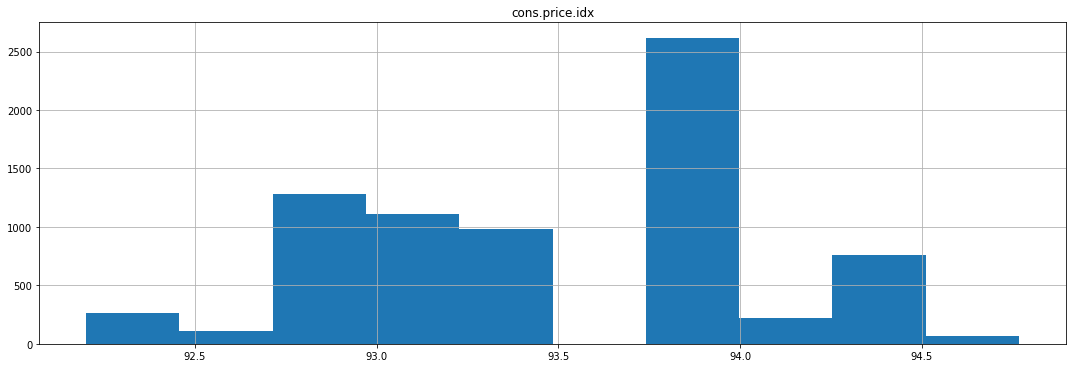

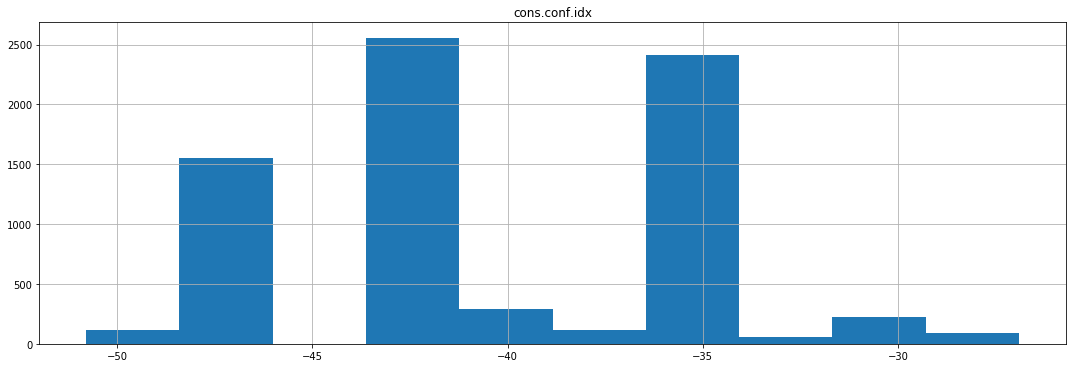

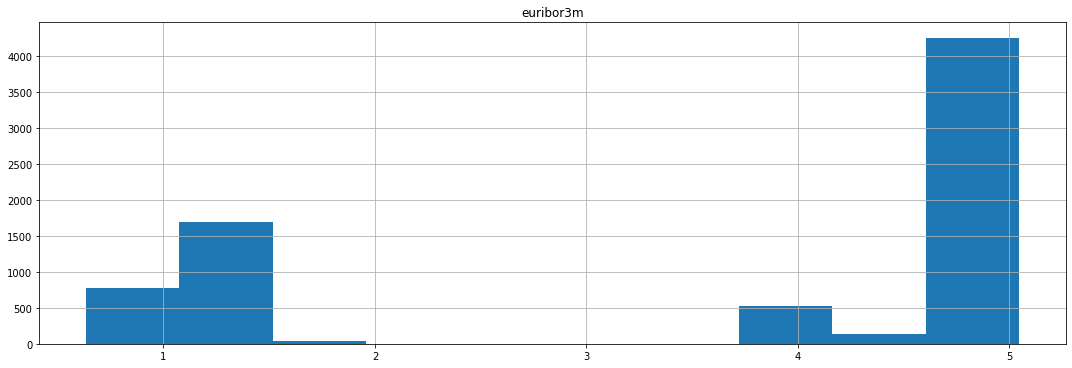

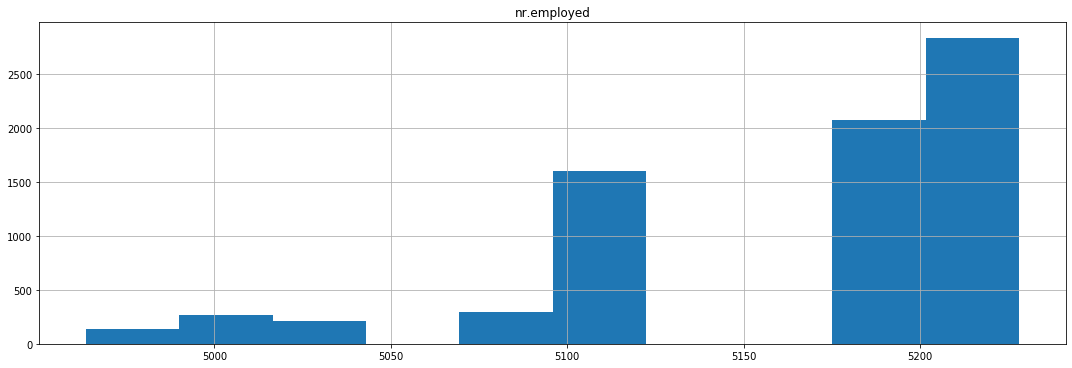

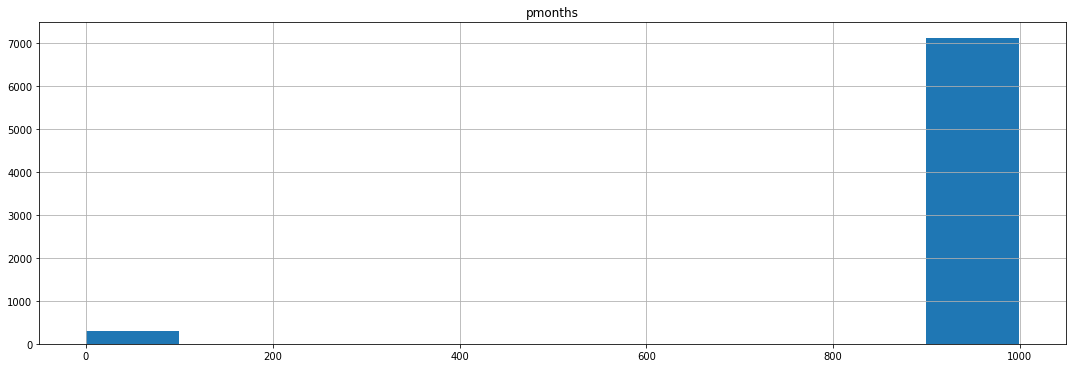

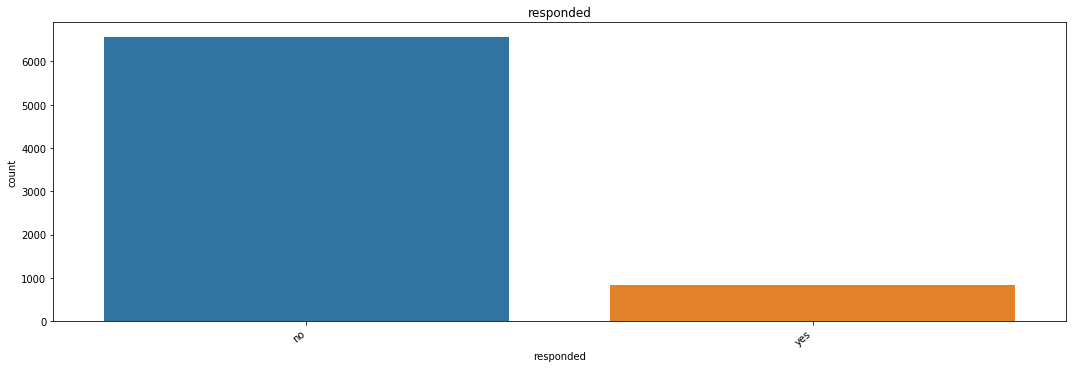

In [248]:
createDistribution(dfRawMarketing.copy())

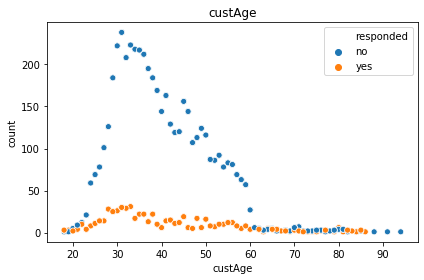

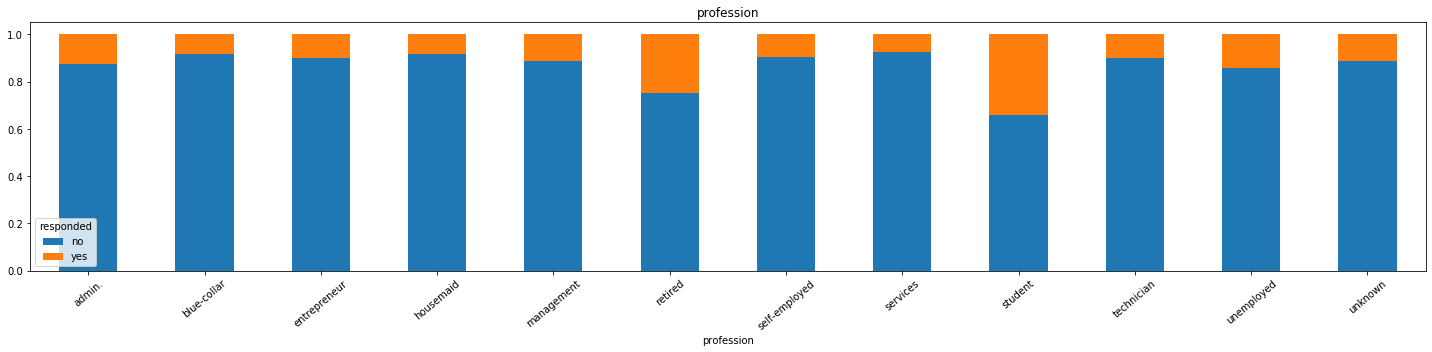

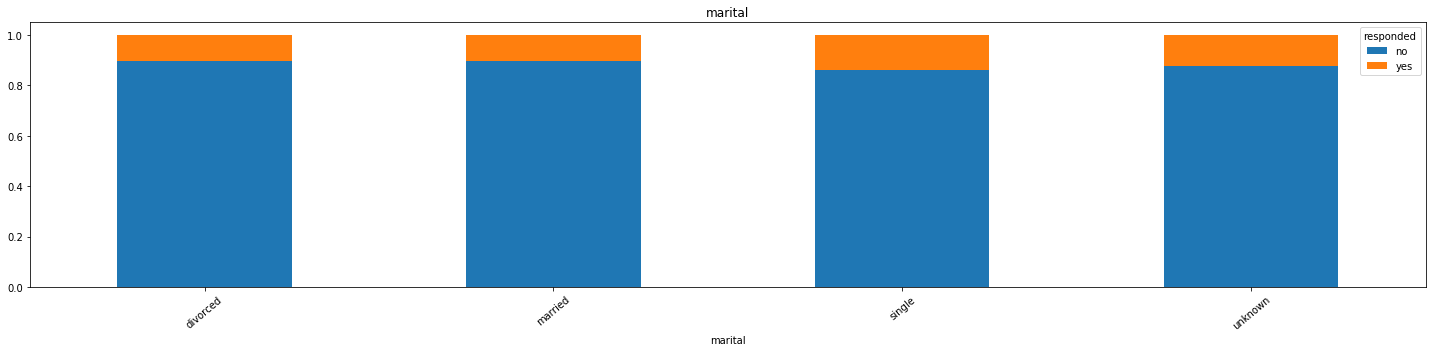

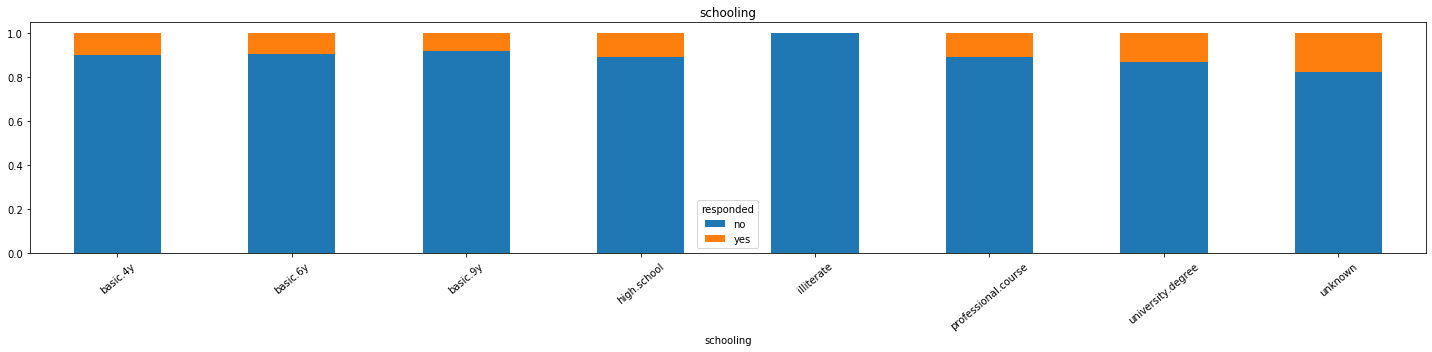

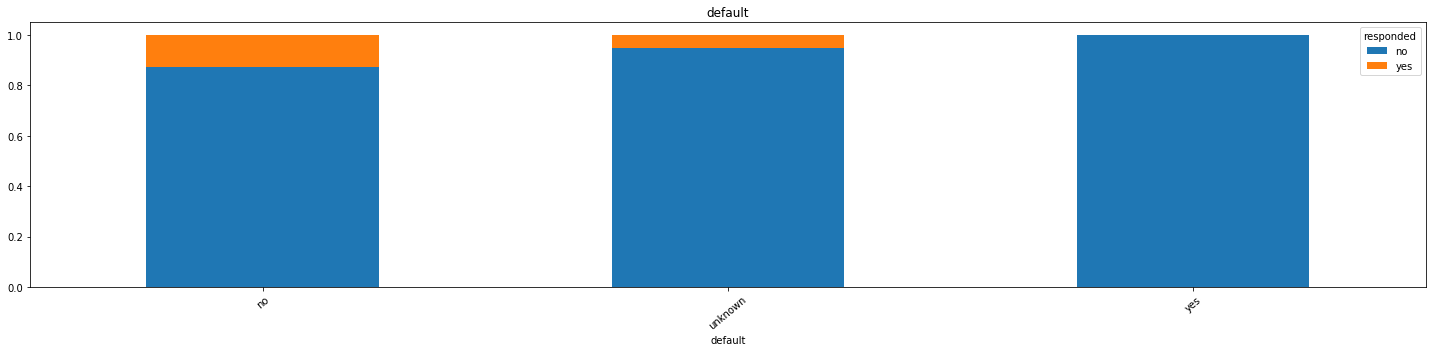

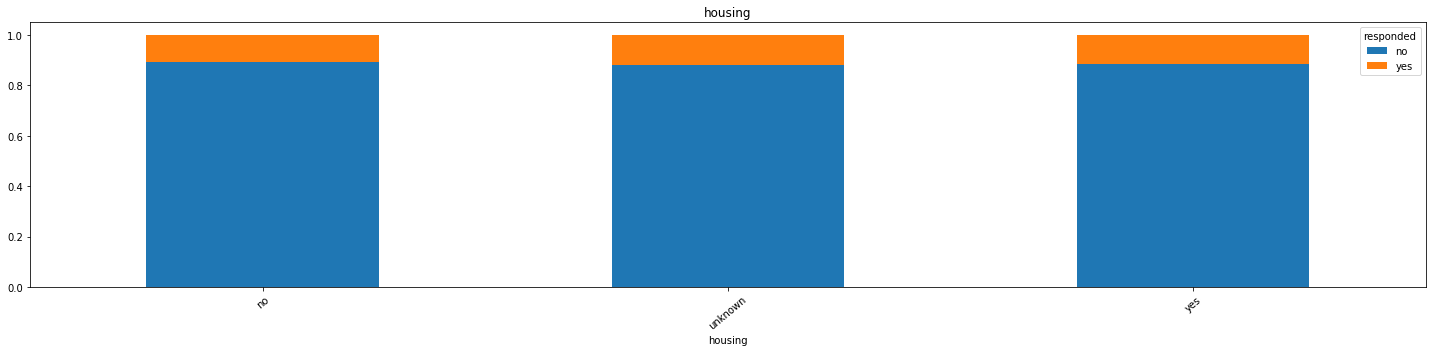

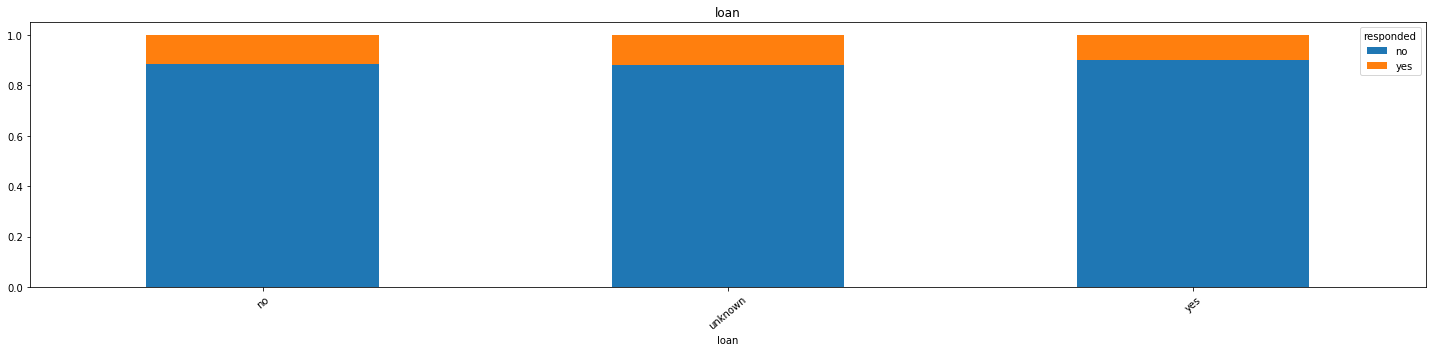

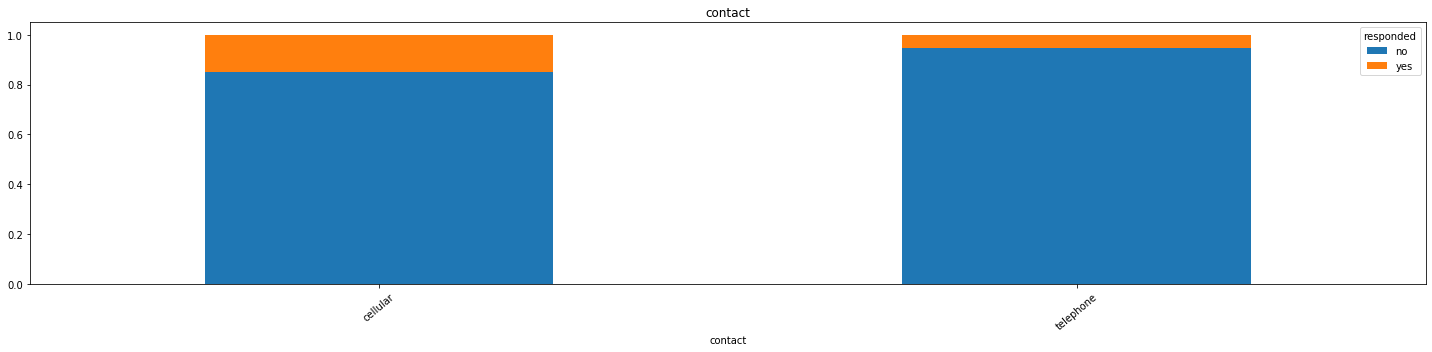

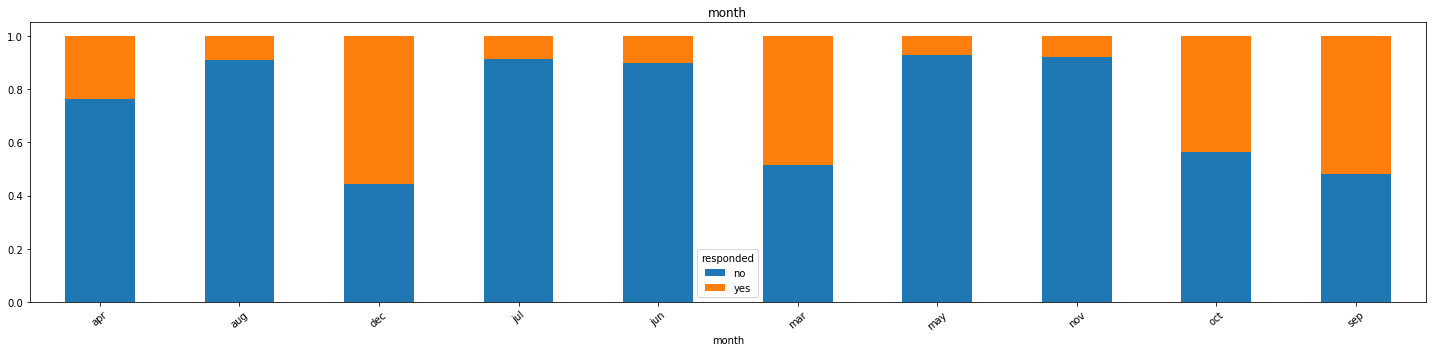

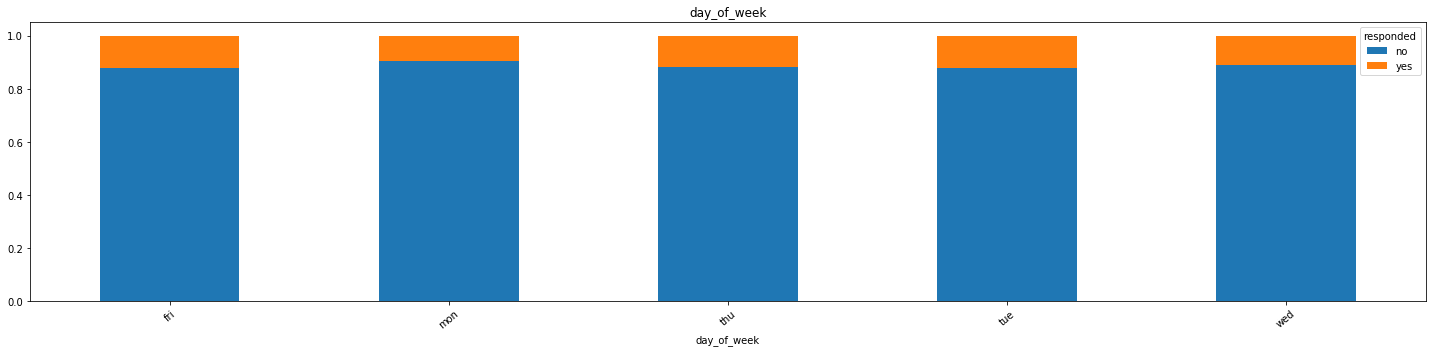

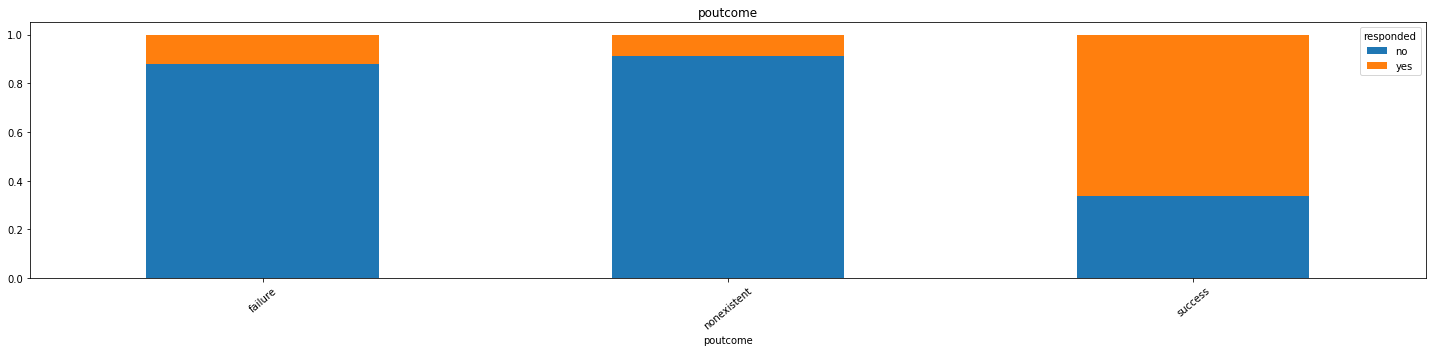

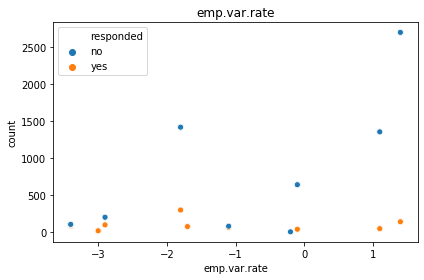

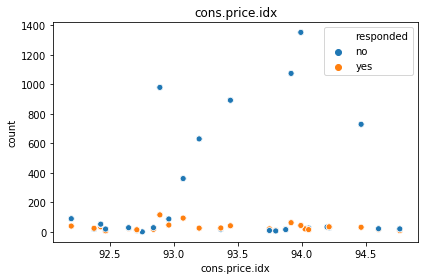

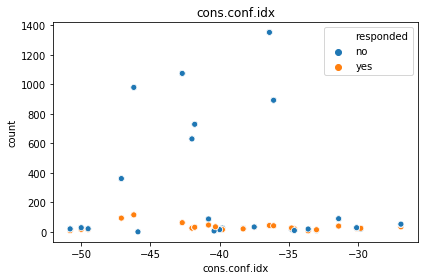

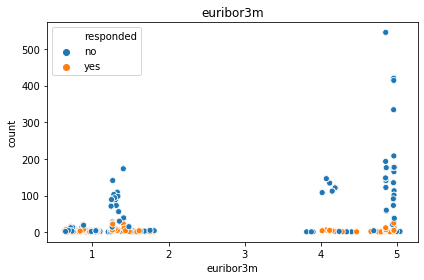

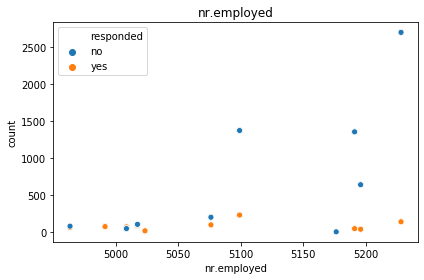

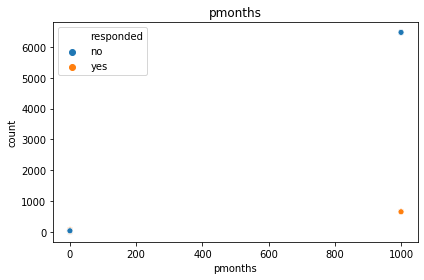

In [249]:
distributionByTarget(dfRawMarketing.copy(),'responded')

In [250]:
#success rate of the the campaign
dfRawMarketing.loc[dfRawMarketing.responded=='yes',['responded']].count()/dfRawMarketing.shape[0]

responded    0.113299
dtype: float64

#### Observations
Boardly the attributes can be classified into three distinct categories. Customer atrributes, campaign related information, and external factors.
- Customer demographics: The age of most of the customers is between 30-60, and majority of customers are married than otherwise. A typical customer is of administration, blue collar or technician profession, and most of the customers have finished atleast a high school degree.<br>
A typical financial porfile customer would be having only house mortage as type of loan with no default history.
- Customer contacts: On a campaign most of the time customers are contacted 0-5 times. With preffered contact method being cellular .
- Campaign periods: Looks most of the contacts or campaigns are on weekdays from the months of Apr-Aug, with small push in Nov.
- Previous campaigns: Most of the customer's have not been contacted yet by any of the previous campaigns. And the campaign had little success with the few people that were previously contacted.
- The success rate of the campaigns has been just over 11%. This creates an imbalance dataset for the target variable.


Campaign response
- Customers within age of 30-60, show wide difference in not responding vs responding to a campaign.
- The percent of students and retiries reponding 'yes' is higher compared to other types of customers.
- Customers with no education or previously responded positively, have not bought policy from current campaigns.
- The porportion of customer replying 'yes' in the months of sep, oct, dec and mar is higher compared to other months.
- Customer with higher number of times been contacted have rarely bought policy.
- Looking at poutcome, if the customer has previously bought the policy, is more likely to buy it again.
- Customer with previous email contacts have more likely to buy a policy.
- External factors by themselves, don't seem to have much of effects on customer response.

### Data Wrangling
Addressing Nulls.<br>
<b>schooling</b>: Looking at the profession, how likely is a person from a certain profession to have certain degree.<br>
<b>day_of_week</b>: The occurances of each of the week in the set is almost same. So filling null values by random selecting any day should be ok.
<b>marital,housing,loan</b>: Since these are such a small numbers replacing them with most frequent value would be ok. 

In [251]:
import numpy as np
dfFilledNA = dfRawMarketing.replace('unknown',np.nan)
dfFilledNA = dfFilledNA.replace(float('nan'),np.nan)
dfFilledNA.isnull().sum()

custAge           1804
profession          61
marital              8
schooling         2386
default           1432
housing            168
loan               168
contact              0
month                0
day_of_week        711
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
pmonths              0
pastEmail            0
responded            0
dtype: int64

In [252]:
#Filling nulls in 'schooling' with most probable value for a profession.
print('Shape before:',dfFilledNA.shape)
dfFilledNA = fillnaWithHighOccrance(dfFilledNA.copy(), ['profession'],'schooling')
# dfFilledNA = dfFilledNA.dropna(subset=['schooling'])
print('Shape after schooling fills:',dfFilledNA.shape)

#Filling nulls in 'default' with most probable value for a combination of custAge and profession.
dfFilledNA = fillnaWithHighOccrance(dfFilledNA.copy(), ['custAge','profession'],'default')
# dfFilledNA = dfFilledNA.dropna(subset=['default'])
print('Shape after default fills:',dfFilledNA.shape)

#Filling nulls in 'profession' with most probable value for a combination of custAge and schooling.
dfFilledNA = fillnaWithHighOccrance(dfFilledNA.copy(), ['custAge','schooling'],'profession')
# dfFilledNA = dfFilledNA.dropna(subset=['profession'])
print('Shape after profession fills:',dfFilledNA.shape)

Shape before: (7414, 22)
Shape after schooling fills: (7414, 22)
Shape after default fills: (7414, 22)
Shape after profession fills: (7414, 22)


In [253]:
import numpy as np

uniqueDays = dfFilledNA.loc[:,'day_of_week'].dropna().unique()

#Recording for future use.
trainingObjects['day_of_week']=uniqueDays
trainingObjects['HighOcc_loan']=dfFilledNA.loc[:,'loan'].mode()[0]
trainingObjects['HighOcc_housing']=dfFilledNA.loc[:,'housing'].mode()[0]
trainingObjects['HighOcc_marital']=dfFilledNA.loc[:,'marital'].mode()[0]

dfFilledNA.loc[:,'day_of_week'] = dfFilledNA['day_of_week'].fillna(pd.Series(np.random.choice(uniqueDays,size= dfFilledNA.shape[0]),index=dfFilledNA.index))
dfFilledNA.loc[:,'loan'] = dfFilledNA.loc[:,'loan'].fillna(trainingObjects['HighOcc_loan'])
dfFilledNA.loc[:,'housing'] = dfFilledNA.loc[:,'housing'].fillna(trainingObjects['HighOcc_housing'])
dfFilledNA.loc[:,'marital'] = dfFilledNA.loc[:,'marital'].fillna(trainingObjects['HighOcc_marital'])

dfFilledNA.isnull().sum()

custAge           1804
schooling            0
profession           0
marital              0
default              0
housing              0
loan                 0
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
pmonths              0
pastEmail            0
responded            0
dtype: int64

<p><b>custAge:</b>This is tricky feature since it is continuous and should have strong correlation with profession, schooling and marital status. For example, a teenager(17) altough not impossible but is less likely to be in management job. Similarly, someone in thier 70s is less likely to be a student.</p>
<p>Hence while filling nulls here should make sense. So the two options that we have is predicting age using linear regression or using random values of a range that is more usual for given comnbination of customer attributes (profession, schooling, marital, housing, loan). Out of which Linear regression should give us results that are relatively closer to the actuals, than the other method.</p>
We prepare the dataset for linear regression, transforming textual information to numeric.

### Transforming features
- Converting all Yes and Nos to 1s and 0s respectively.
- Transforming the schooling values to oridinal form. Combing the basic education years into one as they seem to have similar impact on target value.
- Similarly combing divorced and married into one category, as they both have similar distribution of responsed variable.
- For profession, ideally I would like to combine some of them together and convert them into ordinal form. But with lack of information about them, we pivot them into thier own columns, that is one hot encoding.
- Encoding the months and days of week into respective numbers.
- poutcome, converting success to 1, failure 0 and nonexistance to something in between 0.5.
- pivoting profession, into columns for each values.

In [254]:
dfTransformed = transformFeatures(dfFilledNA.copy())
dfTransformed.columns

Index(['custAge', 'schooling', 'marital', 'default', 'housing', 'loan',
       'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',
       'nr.employed', 'pmonths', 'pastEmail', 'responded', 'contact_cellular',
       'profession_admin.', 'profession_blue-collar',
       'profession_entrepreneur', 'profession_housemaid',
       'profession_management', 'profession_retired',
       'profession_self-employed', 'profession_services', 'profession_student',
       'profession_technician', 'profession_unemployed'],
      dtype='object')

In [255]:
dfPredCustAge = dfTransformed.copy()
dfPredCustAge.loc[dfPredCustAge.custAge.isnull(),'custAge'] = fillnaWtihRegression(dfTransformed.loc[:,custCols],'custAge')
dfPredCustAge.head()

Best Score: -8.593294947952547
dtypes:  marital                     float64
schooling                   float64
default                     float64
housing                     float64
loan                        float64
profession_admin.           float64
profession_blue-collar      float64
profession_entrepreneur     float64
profession_housemaid        float64
profession_management       float64
profession_retired          float64
profession_self-employed    float64
profession_services         float64
profession_student          float64
profession_technician       float64
profession_unemployed       float64
dtype: object


,custAge,schooling,marital,default,housing,loan,month,day_of_week,campaign,pdays,...,profession_blue-collar,profession_entrepreneur,profession_housemaid,profession_management,profession_retired,profession_self-employed,profession_services,profession_student,profession_technician,profession_unemployed
0,55.0,4,0,0,0,0,11,1,1,999,...,0,0,0,0,0,0,0,0,0,0
1,41.0,1,1,0,0,0,7,1,1,999,...,1,0,0,0,0,0,0,0,0,0
2,42.0,2,1,0,0,0,5,1,1,999,...,0,0,0,0,0,0,0,0,1,0
3,55.0,4,1,0,1,1,7,3,2,999,...,0,0,0,1,0,0,0,0,0,0
4,41.0,4,1,0,1,0,5,2,5,999,...,0,0,0,0,0,0,0,0,0,0


In [256]:
#No nulls values remaining.
dfPredCustAge.isnull().any().any()

False

### Feature selection

Selecting features that are less correlated among themselves.
- pmonths and pdays are high degree of correlation among them and exact correlation with responded and other featiures. Selecting pdays as its more granular feature.
- previous and pastEmail, are also highly correlated. Selecting previous as it has better correlation with target variable.
- Another group that is highly correlated is nr.employed, euribor3m and emp.var.rate. Selecting nr.employed as it has slightly better negative correlation with target variable.

C:\Users\patel\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning: 
The label function will be deprecated in a future version. Use Tick.label1 instead.
  fontsize = tick.label.get_size()


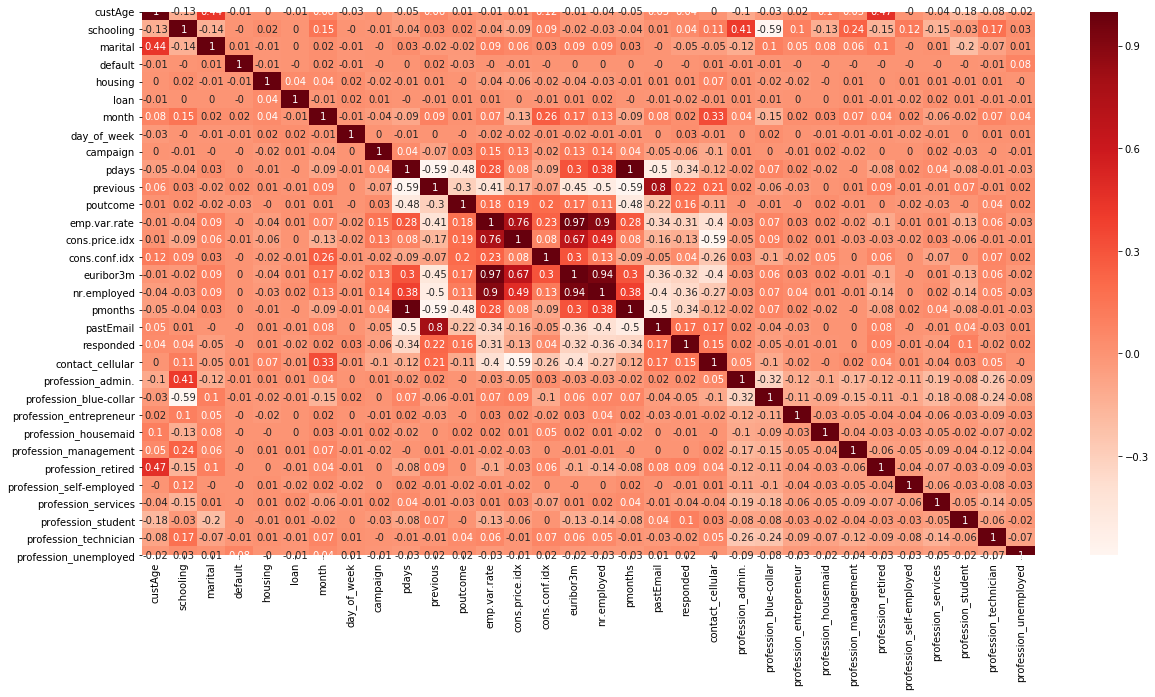

In [257]:
#Plotting correlation coefficients heatmap among features.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,10))
cor = dfPredCustAge.corr().round(2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()
dropColumns = ['pmonths','pastEmail','emp.var.rate','euribor3m']
dfPredCustAge = dfPredCustAge.drop(columns=dropColumns)

In [258]:
#The dataset is still imbalance.
temp_df = pd.DataFrame(dfPredCustAge.loc[:,'responded'])
temp_df.loc[:,'count'] = 1
temp_df = temp_df.pivot_table(columns='responded',values='count',aggfunc='sum')
print('Percent of No in dataset:',round(temp_df[0]/(temp_df[0]+temp_df[1]),2)[0])
print('Percent of Yes in dataset:',round(temp_df[1]/(temp_df[0]+temp_df[1]),2)[0])
del temp_df

Percent of No in dataset: 0.89
Percent of Yes in dataset: 0.11


In [259]:
from imblearn.over_sampling import RandomOverSampler
X = dfPredCustAge.drop(columns='responded')
y = dfPredCustAge.responded

from collections import Counter
print('Before:',Counter(y).items())

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
print('After:',Counter(y_resampled).items())
dfResampled = pd.DataFrame(X_resampled, columns=dfPredCustAge.drop(columns='responded').columns)
dfResampled.loc[:,'responded'] = y_resampled
dfResampled.head()

Before: dict_items([(0, 6574), (1, 840)])
After: dict_items([(0, 6574), (1, 6574)])


,custAge,schooling,marital,default,housing,loan,month,day_of_week,campaign,pdays,...,profession_entrepreneur,profession_housemaid,profession_management,profession_retired,profession_self-employed,profession_services,profession_student,profession_technician,profession_unemployed,responded
0,55.0,4.0,0.0,0.0,0.0,0.0,11.0,1.0,1.0,999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,41.0,1.0,1.0,0.0,0.0,0.0,7.0,1.0,1.0,999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,42.0,2.0,1.0,0.0,0.0,0.0,5.0,1.0,1.0,999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,55.0,4.0,1.0,0.0,1.0,1.0,7.0,3.0,2.0,999.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,41.0,4.0,1.0,0.0,1.0,0.0,5.0,2.0,5.0,999.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


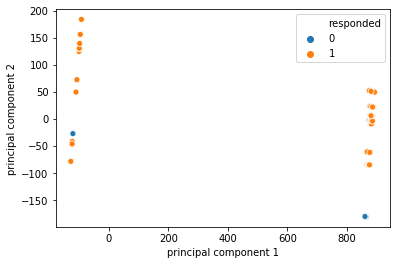

In [260]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pd.get_dummies(dfResampled.drop(columns='responded')))
principalDf = pd.DataFrame(data = principalComponents, \
                           columns = ['principal component 1', 'principal component 2'], \
                           index=dfResampled.index)
dfMerged = principalDf.merge(dfResampled.responded,how='inner',left_index=True,right_index=True)
sns.scatterplot(x='principal component 1',y='principal component 2',data=dfMerged, hue='responded')
plt.show()

C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\patel\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

---------------------------Train Score-------------------------
Best Train Score: 0.9898003868297285
Best Model: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('estimator',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=30,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=-1,
                                        oob_score=False, random_state=42,
                                     

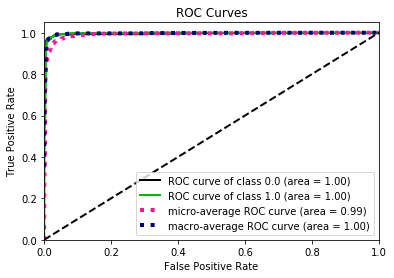

In [261]:
cvModels = getTrainedClassModel(dfResampled,'responded')

### Prediction
Reading test set, predicting values and writing results to marketing_test_results.csv

In [266]:
dfTesting = pd.read_csv('marketing_test.csv', index_col=0)

dfPredictTesting = pd.DataFrame({'responded':predictCustomerForCampaign(dfTesting, custAgeLinearModel)}, index=dfTesting.index)

dfPredictTesting.to_csv('marketing_test_results.csv')

- <b>Describe your model and why did you choose this model over other types of models?</b>
  <p>Random Forest is one of the reference algorithms for me when it comes to building a baseline for classification. It ends being the standard since it is so good at classification problems. As seen by both train and test results it has performed nearly better with all the scores.</p>


- <b>Describe any other models you have tried and why do you think this model performs better?</b>
  <p>Logistic Regression and XGBoost were the other testing algorithms. They did well but when comparing the mean ROC AUC score Random Forest has scored better by a good margin.</p>


- <b>How did you handle missing data?</b>
  <p>There were quite a few records that had missing values in one or more columns. For most of the columns like marital, housing, loan where the nulls were few hundreds, I used the most frequent value. While for day_of_week, since the distribution of records between each day was almost the same, used a random choice value from all the weekdays. For both schooling and default, selected the most frequent value when grouped by (profession) and (profession, custAge) respectively. And despite this, if any records had nulls for these columns, they were dropped.</p>
<p>For custAge, I used linear regression to predict age for all the given customer attributes. This is was one of the better options when compared to other options like a random selection from a range of common age values for certain groups.</p>


- <b>How did you handle categorical (string) data?</b>
  <p>For most of the categorical values, there seems to be some kind of order and hence used ordinal encoding. While for profession needed little more information to go that route, so ended up with One Hot Encoding.</p>
  

- <b>How did you handle unbalanced data?</b>
  <p>After all filling of Nulls and encoding, the positive cases were still accounted for just over 12% of the dataset. Hence used simple oversampling of the positive cases to have a 50/50 split among positive and negative cases. </p>
  

- <b>How did you test your model?</b>
  <p>In this case since the goal was to identify a possible set of customers to target. So here it seemed like capturing the correct set was more important, even if few incorrect customers were sent the marketing campaign information. So here Recall would be a choice of metric but F1 and ROC give a nice balance between overestimating positive cases vs leaving out some. This will ensure there aren’t far too many false positives.</p>